In [1]:
%load_ext autoreload
%autoreload 2
from analysis_settings import *
from plot_settings import *
from scripts.corr_stats import _get_freqs_correlation_stats, _corr_results
from scripts.utils_plot import _save_fig, convert_pvalue_to_asterisks, _add_band_annotations
from scripts.utils import get_correlation_df
import scripts.config as cfg
import numpy as np
from matplotlib.patches import Patch
from itertools import product

In [2]:
n_perm = 10000
# n_perm = None

In [3]:
sns.set_style('darkgrid')
ch_choice = 'ch_dist_sweet'
dataframes = get_dfs(ch_choice, equalize_subjects_norm_abs=False)

c_abs = cfg.COLOR_DIC['absolute']
c_per = cfg.COLOR_DIC['periodic']
c_ap = cfg.COLOR_DIC['periodicAP']
c_norm = cfg.COLOR_DIC['normalized']
c_insig = 'grey'

/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/STN_broadband_power/notebooks/analysis_settings.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['sub_hemi_cond'] = df.sub_hemi + '_' + df.cond
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/STN_broadband_power/notebooks/analysis_settings.py:81: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pivot['UPDRS_exists'] = pivot.UPDRS_bradyrigid_contra.notna()
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/STN_broadband_power/notebooks/analysis_settings.py:82: 

In [4]:
def barplot_UPDRS_periodic_ax(ax, df_corrs, palette=None):
    """Add barplot to correlation plot over freqs."""
    band_cols = df_corrs.band_nme.unique()
    band_nmes = [band.replace(' mean', '') for band in band_cols]
    if palette is None:
        if 'Beta' in band_cols:
            palette = [(sns.color_palette()[0])] + list(sns.color_palette("flare", 2))
        else:
            palette = list(sns.color_palette("flare", 3))

    # barplot
    plot_kwargs = {'ax': ax,
                   'x': 'band_nme',
                   'hue': 'band_nme',
                   'y': 'rho', "order": band_cols,
                   'legend': False, 'data': df_corrs, 'width': 0.6,
                   'palette': palette}
    sns.barplot(**plot_kwargs)
    ax.axhline(0, color='k', lw=LINEWIDTH_AXES, ls='--')

    # add significance star for bars where pval < 0.05
    bars_pooled = ax.containers
    ymin, ymax = ax.get_ylim()
    yscale = ymax - ymin
    for bar, band in zip(bars_pooled, band_cols):
        df_band = df_corrs[(df_corrs.band_nme == band)]
        pvalue = df_band.pval.values[0]
        text = convert_pvalue_to_asterisks(pvalue, stack_vertically=False)
        x_bar = bar[0].get_x() + bar[0].get_width() / 2
        y_bar = bar[0].get_height()
        # offset = max(y_bar, 0) - 0.04 * yscale
        offset = max(y_bar, 0) - 0.06 * yscale
        va = 'bottom'
        ax.annotate(text, xy=(x_bar, offset), ha='center', va=va,
                    fontsize=FONTSIZE_ASTERISK, linespacing=.15)
        print(f'{band}: rho={y_bar:.2f}, pval={pvalue:.2f}')
        # ax.set_ylim(ymin, max(ymax, offset))

    # set axis
    xticks = np.array(ax.get_xticks()) #- 0.5
    # ax.set_xticks(xticks, labels=band_cols, rotation=45, ha='center')
    ax.set_xticks(xticks, labels=band_nmes)
    # ax.set_xticks(xticks, labels=[])
    # ax.set_xticklabels(band_cols)
    ax.set_xlabel(None)
    # ax.spines['bottom'].set_visible(False)
    # ax.spines['left'].set_visible(False)
    # ax.spines['right'].set_visible(True)
    # ax.yaxis.tick_right()
    # ax.yaxis.set_label_position("right")

    # output legend
    handles = [Patch(color=color) for color in palette]
    labels = [band_nme for band_nme in band_nmes]
    return handles, labels


# def export_legend(save_dir, band_cols, palette, fname):
#     handles = [Patch(color=color) for color in palette]
#     labels = [band_nme for band_nme in band_cols]
#     _, new_ax = plt.subplots(1, 1)
#     legend = new_ax.legend(handles, labels, loc=3, framealpha=1,
#                            frameon=True, ncol=1)
#     fig_leg  = legend.figure
#     fig_leg.canvas.draw()
#     bbox  = legend.get_window_extent().transformed(fig_leg.dpi_scale_trans.inverted())
#     filename = join(SAVE_DIR, save_dir, f'{fname}_legend.pdf')
#     fig_leg.savefig(filename, dpi="figure", bbox_inches=bbox,
#                     transparent=False)
#     del fig_leg

#     # flat legend
#     _, new_ax = plt.subplots(1, 1)
#     legend = new_ax.legend(handles, labels, loc=3, framealpha=1,
#                            frameon=True, ncol=len(handles),
#                            handlelength=1, columnspacing=1, handletextpad=0.4)
#     fig_leg  = legend.figure
#     fig_leg.canvas.draw()
#     bbox  = legend.get_window_extent().transformed(fig_leg.dpi_scale_trans.inverted())
#     filename = join(SAVE_DIR, save_dir, f'{fname}_legend_flat.pdf')
#     fig_leg.savefig(filename, dpi="figure", bbox_inches=bbox,
#                     transparent=False)
#     del fig_leg

In [5]:
def df_corr_freq(df_plot, x, y, average_hemispheres=None, rolling_mean=None,
                 xmax=45, corr_method='spearman', n_perm=10000,
                 remove_ties=True,
                 projects=cfg.PROJECT_ORDER_SLIM):
    """Get correlation over each frequency bin."""
    if isinstance(rolling_mean, int) and rolling_mean > 1:
        msg = 'Rolling mean incorrectly implemented for pvalues'
        raise NotImplementedError(msg)
    df_corrs = []
    projects = [proj for proj in projects if proj in df_plot.project.unique()]
    if average_hemispheres is None:
        if y == 'UPDRS_III':
            average_hemispheres = True
        elif 'contra' in y:
            average_hemispheres = False
    for project in projects:
        df_proj = df_plot[df_plot.project == project]
        df_corr = _get_freqs_correlation_stats(df_proj, x, y,
            average_hemispheres, xmax, corr_method=corr_method,
            remove_ties=remove_ties, n_perm=n_perm)
        df_corrs.append(df_corr)
    df_corrs = pd.concat(df_corrs, ignore_index=True)
    return df_corrs


def plot_psd_updrs_correlation(df_corrs, x, y, kind, save_dir=None):
    projects = [proj for proj in cfg.PROJECT_ORDER_SLIM
                if proj in df_corrs.project.unique()]
    # sample_sizes = [(df_plot.project == proj).sum() for proj in projects]
    # line_widths = {proj: 1/60 * sample_sizes[i]
    #                for i, proj in enumerate(projects)}
    updrs = y.replace('UPDRS_', '').replace('III', 'III_mean')
    line_widths = {proj: .25 for proj in projects}
    line_widths['all'] = 1

    if x in ['psd', 'asd', 'psd_log']:
        x_plot = "psd_freqs"
    elif 'fm' in x:
        x_plot = "fm_freqs"
    y_plot = f"corr_{x}_{y}"
    y_pval = f"pval_{x}_{y}"
    cond = df_corrs.cond.unique()[0]
    n_perm = df_corrs.n_perm.unique()[0]
    xmax = df_corrs[x_plot].max()

    fig, ax = plt.subplots(1, 1, figsize=(2, 1.3))
    for project in projects:
        df_corr = df_corrs[df_corrs.project == project]
        lw = line_widths[project]
        sample_size = df_corr.sample_size.unique()[0]
        if 'contra' not in y:
            sample_size_str = f'{cfg.SAMPLE_PAT}={sample_size}'
        else:
            sample_size_str = f'{cfg.SAMPLE_STN}={sample_size}'
        # sample_size_str = rf'$n={sample_size}$'
        # label = (f"{cfg.COND_DICT[cond]}\n"
        label = (f"{cfg.COND_DICT[cond]} {sample_size_str}"
        # label = (f"{cfg.COND_DICT[cond]} "
                #  rf"($n={{{sample_size}}}$)"
                #  f"(n={sample_size})"
                 if project == 'all' else None)
        sns.lineplot(data=df_corr, ax=ax, x=x_plot, lw=lw, y=y_plot,
                     label=label, color=cfg.COLOR_DIC[project + "3"])

        if project == 'all':
            freqs_significant = df_corr[y_pval] < 0.05
            ymin, ymax = ax.get_ylim()
            x_arr = df_corr[x_plot].values.astype(float)
            # freqs_sig = x_arr[freqs_significant].copy()
            # ax.fill_between(df_corr[x_plot], 0, df_corr[y_plot], color='k',
            #                 alpha=0.2, where=freqs_significant,
            #                 label='p < 0.05')
            y_arr = np.ones_like(x_arr) * ymin
            x_arr[~freqs_significant] = np.nan
            y_arr[~freqs_significant] = np.nan
            ax.plot(x_arr, y_arr, color=cfg.COLOR_DIC[project + "3"],
                    # label='p < 0.05',
                    lw=1)
            ax.legend(handlelength=1, loc='upper right',
                    #   bbox_to_anchor=(1, 1.1)
                      )
            ax.set_ylim(ymin-.02, ymax)

            # Find indices where the difference between consecutive elements is greater than 1
            x_arr = x_arr[~np.isnan(x_arr)]
            diff = np.diff(x_arr)
            breaks = np.where(diff > 1)[0]
            # Split the array into clusters based on the breaks
            clusters = np.split(x_arr, breaks + 1)
            # Format the clusters into desired range strings
            formatted_clusters = [f"{cluster[0]:.0f}-{cluster[-1]:.0f} Hz" for cluster in clusters]
            output = ", ".join(formatted_clusters)
            print('\n')
            print("Significant clusters:", output)
            print('\n')
            # print('Significant freqs:', x_arr[~np.isnan(x_arr)])
    ax.set_xlim((0, df_corrs[x_plot].max()))
    ax.hlines(0, *ax.get_xlim(), color='k', lw=LINEWIDTH_AXES, ls='--')
    corr_method = df_corrs.corr_method.unique()[0]
    # cond_str = f' {cfg.COND_DICT[cond]}'
    ylabel = _get_ylabel(corr_method)
    ax.set_ylabel(ylabel)
    ax.set_xticks(XTICKS_FREQ_low)
    ax.set_xticklabels(XTICKS_FREQ_low_labels)
    # ax.set_ylabel(ylabel + cond_str)
    # ax.set_xlabel(None)
    ax.set_xlabel('Frequency [Hz]')
    plt.tight_layout()
    if save_dir:
        _save_fig(fig, f'{save_dir}/psd_UPDRS_correlation_{corr_method}_'
                  f'{kind}_{cond}_{updrs}_{xmax}Hz_nperm={n_perm}', SAVE_DIR,
                  bbox_inches=None, close=False);


def _get_ylabel(corr_method):
    # x = df['x'].unique()[0]
    # updrs = df['y'].unique()[0]
    # corr_method = df.corr_method.unique()[0]
    # if 'fm_fooofed_spectrum' in x:
    #     pwr = 'Full Pwr.'
    # elif 'fm_psd_peak_fit' in x:
    #     pwr = 'Periodic Pwr.'
    # elif 'fm_psd_ap_fit' in x:
    #     pwr = 'Aperiodic Pwr.'
    # elif 'abs_max' in x or 'psd' in x:
    #     pwr = 'PSD'
    # else:
    #     raise ValueError(f'Unknown x: {x}')
    # updrs_str = cfg.PLOT_LABELS[updrs]
    # if updrs == 'UPDRS_bradyrigid_contra':
    #     updrs_str = 'BR'
    # elif updrs == 'UPDRS_III':
    #     updrs_str = 'UPDRS-III'
    if corr_method == 'spearman':
        # ylabel = r"Spearman $\rho$ "
        # ylabel = f'{pwr} ~ {updrs_str} 'r'[$\rho$]'
        ylabel = r'$\rho$'
    elif corr_method == 'within':
        ylabel = r"$r_{rm}$"
    elif corr_method == 'withinRank':
        ylabel = r"$r_{\text{rank rm}}$"
    return ylabel


def plot_psd_updrs_correlation_and_bar(df_corrs, df_corrs_bar,
                                       save_dir=None, figsize=(2.6, 1.5),
                                       legend=False, palette_barplot=None,
                                       band_annos=None, xmin=2,
                                       info_title=False,
                                       ylim=None, fill_significance=False):
    assert df_corrs.project.nunique() == 1
    kinds = '_'.join(kind for kind in df_corrs.kind.unique())
    x = df_corrs['x'].unique()[0]
    y = df_corrs['y'].unique()[0]
    updrs = y.replace('UPDRS_', '').replace('III', 'III_mean')

    if x in ['psd', 'asd', 'psd_log']:
        x_plot = "psd_freqs"
    elif 'fm' in x:
        x_plot = "fm_freqs"
    # x_plot = "psd_freqs"
    y_plot = f"corr_{x}_{y}"
    y_pval = f"pval_{x}_{y}"
    conds = df_corrs.cond.unique()
    kinds = df_corrs.kind.unique()
    n_perm = df_corrs.n_perm.unique()[0]
    xmax = df_corrs[x_plot].max()
    if df_corrs_bar is None:
        fig, axes = plt.subplots(1, 1, figsize=figsize, sharey=True)
        # plot correlation over freqs
        ax = axes
    else:
        corr_method = df_corrs.corr_method.unique()[0]
        if corr_method == 'spearman':
            width_ratios = [1, 0.4]
        elif corr_method.startswith('within'):
            width_ratios = [1, 0.2 * len(df_corrs_bar.band_nme.unique())]
        fig, axes = plt.subplots(1, 2, figsize=figsize,
                                 width_ratios=width_ratios, sharey=True)
        # plot correlation over freqs
        ax = axes[0]
    for cond in conds:
        for kind in kinds:
            df_corr = df_corrs[(df_corrs.kind == kind) & (df_corrs.cond == cond)]
            # label = (f"{cfg.KIND_DICT[kind]}")
            label = cfg.COND_DICT[cond]
            c = '2' if cond == 'on' else ''
            color = cfg.COLOR_DIC[kind + c]
            sns.lineplot(data=df_corr, ax=ax, x=x_plot, lw=1, y=y_plot,
                        label=label, color=color)
            freqs_significant = df_corr[y_pval] < 0.05

            sample_size = df_corr['sample_size'].unique()[0]
            if df_corr['hemispheres_averaged'].unique()[0]:
                sampling_str = 'sub'
            else:
                sampling_str = 'hemi'
            sample_size_str = rf'{kind} {cond} $n_{{{sampling_str}}}={sample_size}$'
            print(sample_size_str)

            # Find indices where the difference between consecutive elements is greater than 1
            x_arr = df_corr[x_plot].values.astype(float)
            x_arr[~freqs_significant] = np.nan
            x_arr = x_arr[~np.isnan(x_arr)]
            diff = np.diff(x_arr)
            breaks = np.where(diff > 1)[0]
            # Split the array into clusters based on the breaks
            clusters = np.split(x_arr, breaks + 1)
            # Format the clusters into desired range strings
            formatted_clusters = [f"{cluster[0]:.0f}-{cluster[-1]:.0f} Hz" for cluster in clusters]
            output = ", ".join(formatted_clusters)
            print('\n')
            print("Significant clusters:", output)
            print('\n')
            if fill_significance:
                if freqs_significant.sum() > 0:
                    ax.fill_between(df_corr[x_plot], 0, df_corr[y_plot],
                                    color=color, alpha=0.2,
                                    where=freqs_significant, label=None)

    # set axis
    ax.axhline(0, color='k', lw=LINEWIDTH_AXES, ls='--')
    corr_method = df_corrs.corr_method.unique()[0]
    if corr_method == 'spearman':
        # ylabel = r"Spearman $\rho$ "
        ylabel = r"$\rho$"
    elif corr_method == 'within':
        ylabel = r"$r_{rm}$"
    elif corr_method == 'withinRank':
        ylabel = r"$r_{\text{rank rm}}$"
    ax.set_ylabel(ylabel)
    alpha = 1 if cond == 'on' else 0
    ax.set_xlabel('Frequency [Hz]', alpha=alpha)
    handles, labels = ax.get_legend_handles_labels()

    # bar plot
    # smoothing = df_corrs.rolling_mean.unique()[0]
    asymmetric_subjects = df_corrs.asymmetric_subjects.unique()[0]
    if asymmetric_subjects == True:
        consistent_str = '_consistent'
    elif asymmetric_subjects == False:
        consistent_str = '_inconsistent'
    elif asymmetric_subjects is None:
        consistent_str = ''
    # dominant_side_consistent = df_corrs.dominant_side_consistent.unique()[0]
    # if dominant_side_consistent == True:
    #     consistent_str = '_consistent'
    # elif dominant_side_consistent == False:
    #     consistent_str = '_inconsistent'
    # elif dominant_side_consistent is None:
    #     consistent_str = ''
    log = '_log' if x.endswith('_log') else ''
    if df_corrs_bar is not None:
        bar_str = 'Hz+bar'
        handles_bar, labels_bar = barplot_UPDRS_periodic_ax(axes[1],
                                                            df_corrs_bar,
                                                            palette=palette_barplot)
    else:
        bar_str = ''
    kind_str = '_'.join(kinds)
    fname = (f'psd{log}_UPDRS_correlation_{corr_method}_'
             f'{kind_str}_{cond}_{updrs}_{xmax}Hz{bar_str}'  # smooth={smoothing}'
             f'{consistent_str}_nperm={n_perm}')

    # legend
    # ax.legend().remove()
    # if legend:
    #     # data_min = df_corrs[y_plot].min() - 0.04 # 0.06
    #     # fig.legend(handles=handles + handles_bar, labels=labels + labels_bar,
    #     y_min, y_max = ax.get_ylim()
    #     x_min, x_max = ax.get_xlim()
    #     fig.legend(handles=handles, labels=labels,
    #             #   ncol=1,
    #               handlelength=1,
    #             # columnspacing=1, labelspacing=0.4,
    #             #   handletextpad=0.6,
    #             #   loc='upper right', bbox_to_anchor=(x_max, y_max),
    #             #   bbox_transform=ax.transData,
    #               )
        # _, ymax = ax.get_ylim()
        # if corr_method == 'within':
        #     if kind in ['normalizedInce', 'lorentzian', 'lorentzianAP', 'lorentzianFULL']:
        #         ymin = -.53
        #     elif kind in ['normalized', 'absolute', 'periodic', 'periodicAP', 'periodicFULL']:
        #         ymin = -.75
        # elif corr_method == 'withinRank':
        #     if kind in ['normalizedInce', 'lorentzian', 'lorentzianAP', 'lorentzianFULL']:
        #         ymin = -.8
        #     elif kind in ['normalized', 'absolute', 'periodic', 'periodicAP', 'periodicFULL']:
        #         ymin = -.8
        # elif corr_method == 'spearman':
        #     if kind in ['normalizedInce', 'lorentzian', 'lorentzianAP', 'lorentzianFULL']:
        #         ymin = -.6
        #     elif kind in ['normalized', 'absolute', 'periodic']:
        #         ymin = -.8
        # ax.set_ylim(ymin, ymax)
    if legend:
        ax.legend()
    else:
        ax.legend().remove()


    # horizontal lines for significance - do at the end for correct axis limits
    if ylim is not None:
        ax.set_ylim(ylim)
    ymin, ymax = ax.get_ylim()
    yscale = ymax - ymin
    # offset = ymin + 0.02 * yscale
    ydiff = 0.025 * yscale
    offset = ymin - ydiff/2
    for cond in conds:
        for kind in reversed(kinds):
            df_corr = df_corrs[(df_corrs.kind == kind) & (df_corrs.cond == cond)]
            # color = cfg.COLOR_DIC[kind]
            c = '2' if cond == 'on' else ''
            color = cfg.COLOR_DIC[kind + c]
            freqs_significant = df_corr[y_pval] < 0.05
            if freqs_significant.sum() > 0:
                # Add horizontal lines for significance
                significant_freqs = df_corr[x_plot][freqs_significant].values
                splits = np.where(np.diff(significant_freqs) != 1)[0] + 1
                clusters = np.split(significant_freqs, splits)
                for cluster in clusters:
                    ax.plot([cluster[0], cluster[-1]],
                            [offset, offset], color=color, lw=1)
                offset += ydiff
    ax.set_ylim(ymin - ydiff*1.5, ymax)
    if xmax == 45:
        if df_corrs_bar is None:
            xticks = XTICKS_FREQ_low + [60]
            labels = XTICKS_FREQ_low_labels + [60]
        else:
            # skip last xtick at 100 Hz due to barplot xticks
            xticks = XTICKS_FREQ_low[:-1]
            labels = XTICKS_FREQ_low_labels[:-1]
    elif xmax == 60:
        if df_corrs_bar is None:
            xticks = XTICKS_FREQ_high
            labels = XTICKS_FREQ_high_labels
            # labels[-2] = ''  # remove 60 Hz
        else:
            # skip last xtick at 100 Hz due to barplot xticks
            xticks = XTICKS_FREQ_high
            labels = XTICKS_FREQ_high_labels
            labels[-2] = ''  # remove 60 Hz
            # xticks = XTICKS_FREQ_low  # + [60]
            # labels = XTICKS_FREQ_low  # + [60]
    else:
        if df_corrs_bar is None:
            # xticks = XTICKS_FREQ_low + list(np.arange(60, xmax + 1, 20))
            xticks = XTICKS_FREQ_high
            labels = XTICKS_FREQ_high_labels
        else:
            # skip last xtick at 100 Hz due to barplot xticks
            # xticks = XTICKS_FREQ_low + list(np.arange(60, xmax, 20))
            xticks = XTICKS_FREQ_high[:-1]
            labels = XTICKS_FREQ_high_labels[:-1]
        # ax.set_xscale('log')
    # if kind in ['normalizedInce', 'lorentzian']:
    #     xticks = XTICKS_FREQ[1:] + [xmax]
    # else:
    #     xticks = XTICKS_FREQ
    ax.set_xticks(xticks, labels=labels)
    ax.set_xlim((xmin, df_corrs[x_plot].max()))

    # invisible = True if kind != 'absolute' else False
    # short = False if kind == 'absolute' else True
    _add_band_annotations(band_annos, ax, short=False, y=1.07,
                          invisible=False)  # do after setting xlim
    if info_title:
        # else:
            # sample_size_str = rf' ($n_{{{hemi}}}={sample_size}$)'
        kind_str = cfg.KIND_DICT[kind]
        cond_str = cfg.COND_DICT[cond]
        updrs_str = cfg.PLOT_LABELS[y]
        ax.set_title(f'{kind_str}, {cond_str}, {updrs_str}, {sample_size_str}')
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.0025)
    # plt.subplots_adjust(wspace=-.05)
    if save_dir:
        _save_fig(fig, join(save_dir, fname), SAVE_DIR, close=False,
                  transparent=False,
                  bbox_inches=None);


def figure2(kinds=['normalized', 'absolute', 'periodic'],
            conds=['offon_abs'], n_perm=10000, xmax=45,
            asymmetric_subjects=None,
            # y="UPDRS_bradyrigid_contra",
            y="UPDRS_III", ylim=None,
            corr_method='spearman'):
    df_corr_bar = None
    for cond in conds:
        df_corrs_all = []
        for kind in kinds:
            # if kind in ['normalized', 'absolute', 'periodic']:
            folder = 'Figure2'
            # else:
                # folder = 'Supp4'
            save_dir = f'{folder}/{ch_choice}/'

            if kind == 'normalized':
                df_plot = dataframes['df_norm']
                x = 'psd_log'
                # xmax = 45
            elif kind == 'normalizedInce':
                df_plot = dataframes['df_normInce']
                x = 'psd_log'
            elif kind  == 'absolute':
                df_plot = dataframes['df_abs']

                # subs5 = ['FloML001', 'FloML004', 'FloML005', 'FloML006', 'FloML007', 'FloML013', 'FloML014', 'FloML015', 'FloML016', 'FloML018', 'FloML020', 'FloML023', 'FloML024', 'FloML025', 'FloML026', 'FloML027', 'FloML028', 'HirML001', 'HirML003', 'HirML006', 'HirML007', 'HirML008', 'HirML010', 'HirML012', 'HirML013', 'HirML014', 'HirML015', 'HirML018', 'HirML019', 'HirML021', 'LitML002', 'LitML004', 'LitML005', 'LitML008', 'LitML009', 'LitML012', 'LitML013', 'NeuEL003', 'NeuEL004', 'NeuEL006', 'NeuEL007', 'NeuEL009', 'NeuEL010', 'NeuEL012', 'NeuEL016', 'NeuEL017', 'NeuEL019', 'NeuEL021', 'NeuEL024', 'NeuEL026', 'NeuEL027', 'NeuEL030', 'NeuL005', 'NeuL012', 'NeuL013', 'NeuL015', 'NeuL016', 'NeuL017', 'TanL002', 'TanL003', 'TanL009', 'TanL012', 'TanL014']
                # df_plot = df_plot[df_plot.subject.isin(subs5)]


                x = 'psd_log'
                palette_barplot = [c_abs, c_abs, c_abs]
                band_annos = BANDS
                band_cols = [
                    # 'delta_abs_mean_log',
                    # 'theta_alpha_abs_mean_log',
                            'theta_abs_mean_log',
                             'beta_low_abs_mean_log',
                             'gamma_low_abs_mean_log']
                data = df_plot[(df_plot.cond == cond)
                                & (df_plot.project == 'all')]
                df_corr_bar = get_correlation_df(data, y, total_power=True,
                                    use_peak_power=True, n_perm=n_perm,
                                    band_cols=band_cols,
                                    corr_method=corr_method)
                df_corr_bar['kind'] = kind
                # xmax = 45
                # xmax = 100
            elif kind  == 'periodic':
                df_plot = dataframes['df_per']


                # subs5 = ['FloML001', 'FloML004', 'FloML005', 'FloML006', 'FloML007', 'FloML013', 'FloML014', 'FloML015', 'FloML016', 'FloML018', 'FloML020', 'FloML023', 'FloML024', 'FloML025', 'FloML026', 'FloML027', 'FloML028', 'HirML001', 'HirML003', 'HirML006', 'HirML007', 'HirML008', 'HirML010', 'HirML012', 'HirML013', 'HirML014', 'HirML015', 'HirML018', 'HirML019', 'HirML021', 'LitML002', 'LitML004', 'LitML005', 'LitML008', 'LitML009', 'LitML012', 'LitML013', 'NeuEL003', 'NeuEL004', 'NeuEL006', 'NeuEL007', 'NeuEL009', 'NeuEL010', 'NeuEL012', 'NeuEL016', 'NeuEL017', 'NeuEL019', 'NeuEL021', 'NeuEL024', 'NeuEL026', 'NeuEL027', 'NeuEL030', 'NeuL005', 'NeuL012', 'NeuL013', 'NeuL015', 'NeuL016', 'NeuL017', 'TanL002', 'TanL003', 'TanL009', 'TanL012', 'TanL014']
                # df_plot = df_plot[df_plot.subject.isin(subs5)]


                x = 'fm_psd_peak_fit_log'
                # data = df_plot[(df_plot.cond == cond)
                #                     & (df_plot.project == 'all')]
                # df_corr_bar = get_correlation_df(data, y, total_power=False,
                #                     use_peak_power=True, n_perm=n_perm,
                #                     add_high_beta=False,
                #                     bands=[], corr_method=corr_method)
                # df_corr_bar['kind'] = kind
            elif kind  == 'periodicAP':
                df_plot = dataframes['df_per']
                x = 'fm_psd_peak_fit_log'
                data = df_plot[(df_plot.cond == cond)
                                    & (df_plot.project == 'all')]
                df_corr_bar = get_correlation_df(data, y, total_power=False,
                                    use_peak_power=True, n_perm=n_perm,
                                    bands=[], corr_method=corr_method)
                df_corr_bar['kind'] = kind
            elif kind  == 'periodicFULL':
                df_plot = dataframes['df_per']
                x = 'fm_fooofed_spectrum_log'
                xmax = 40  # max for fm Litvak
                # data = df_plot[(df_plot.cond == cond)
                #                     & (df_plot.project == 'all')]
                # df_corr_bar = get_correlation_df(data, y, total_power=False,
                #                     use_peak_power=True, n_perm=n_perm,
                #                     add_high_beta=False,
                #                     bands=[], corr_method=corr_method)
                # df_corr_bar['kind'] = kind

            if kind.startswith('periodic'):
                data = df_plot[(df_plot.cond == cond)
                                & (df_plot.project == 'all')]
                palette_barplot = [c_ap, c_per, c_per]
                band_annos = BANDS
                band_cols = ['fm_offset_log',
                            #  'delta_theta_fm_powers_max_log',
                             'beta_low_fm_mean_log',
                             'gamma_low_fm_mean_log',
                             ]
                df_corr_bar = get_correlation_df(data, y, total_power=False,
                                    use_peak_power=True, n_perm=n_perm,
                                    bands=None,
                                    band_cols=band_cols,
                                    corr_method=corr_method)
                df_corr_bar['kind'] = kind

            data = df_plot[(df_plot.cond == cond) & (df_plot.project == 'all')]
            df_corrs = df_corr_freq(data, x, y, corr_method=corr_method,
                                    n_perm=n_perm, xmax=xmax)
            df_corrs['kind'] = kind
            df_corrs['n_perm'] = n_perm
            df_corrs['asymmetric_subjects'] = asymmetric_subjects
            # df_corrs.rename(columns=rename_periodic, inplace=True)
            df_corrs_all.append(df_corrs)
        df_corrs_all = pd.concat(df_corrs_all)
        # x = rename_periodic[x]
        plot_psd_updrs_correlation_and_bar(df_corrs_all, df_corr_bar,
                                           save_dir=save_dir,
                                           legend=False, ylim=ylim,
                                           palette_barplot=palette_barplot,
                                           band_annos=band_annos,
                                        #    figsize=(3.5, 1.5))
                                           figsize=(3.5, 1.2))

rename_periodic = {'fm_freqs': 'psd_freqs',
                    'fm_psd_peak_fit': 'psd',
                    'fm_psd_peak_fit_log': 'psd_log',
                    'fm_psd_ap_fit': 'psd',
                    'fm_psd_ap_fit_log': 'psd_log',
                    'fm_fooofed_spectrum': 'psd',
                    'fm_fooofed_spectrum_log': 'psd_log',
                    'psd': 'psd',
                    'psd_log': 'psd_log',
                    'corr_fm_psd_peak_fit_UPDRS_bradyrigid_contra': 'corr_psd_UPDRS_bradyrigid_contra',
                    'pval_fm_psd_peak_fit_UPDRS_bradyrigid_contra': 'pval_psd_UPDRS_bradyrigid_contra',
                    'corr_fm_psd_peak_fit_log_UPDRS_bradyrigid_contra': 'corr_psd_log_UPDRS_bradyrigid_contra',
                    'pval_fm_psd_peak_fit_log_UPDRS_bradyrigid_contra': 'pval_psd_log_UPDRS_bradyrigid_contra',
                    'corr_fm_psd_ap_fit_UPDRS_bradyrigid_contra': 'corr_psd_UPDRS_bradyrigid_contra',
                    'pval_fm_psd_ap_fit_UPDRS_bradyrigid_contra': 'pval_psd_UPDRS_bradyrigid_contra',
                    'corr_fm_psd_ap_fit_log_UPDRS_bradyrigid_contra': 'corr_psd_log_UPDRS_bradyrigid_contra',
                    'pval_fm_psd_ap_fit_log_UPDRS_bradyrigid_contra': 'pval_psd_log_UPDRS_bradyrigid_contra',
                    'pval_fm_psd_peak_fit_log_UPDRS_bradyrigid_contra': 'pval_psd_log_UPDRS_bradyrigid_contra',
                    'corr_fm_fooofed_spectrum_UPDRS_bradyrigid_contra': 'corr_psd_UPDRS_bradyrigid_contra',
                    'pval_fm_fooofed_spectrum_UPDRS_bradyrigid_contra': 'pval_psd_UPDRS_bradyrigid_contra',
                    'corr_fm_fooofed_spectrum_log_UPDRS_bradyrigid_contra': 'corr_psd_log_UPDRS_bradyrigid_contra',
                    'pval_fm_fooofed_spectrum_log_UPDRS_bradyrigid_contra': 'pval_psd_log_UPDRS_bradyrigid_contra',
                    'corr_fm_psd_peak_fit_UPDRS_III': 'corr_psd_UPDRS_III',
                    'pval_fm_psd_peak_fit_UPDRS_III': 'pval_psd_UPDRS_III',
                    'corr_fm_psd_ap_fit_UPDRS_III': 'corr_psd_UPDRS_III',
                    'pval_fm_psd_ap_fit_UPDRS_III': 'pval_psd_UPDRS_III',
                    'corr_fm_psd_ap_fit_log_UPDRS_III': 'corr_psd_log_UPDRS_III',
                    'pval_fm_psd_ap_fit_log_UPDRS_III': 'pval_psd_log_UPDRS_III',
                    'corr_fm_psd_peak_fit_log_UPDRS_III': 'corr_psd_log_UPDRS_III',
                    'pval_fm_psd_peak_fit_log_UPDRS_III': 'pval_psd_log_UPDRS_III',
                    'pval_fm_psd_peak_fit_log_UPDRS_III': 'pval_psd_log_UPDRS_III',
                    'corr_fm_fooofed_spectrum_UPDRS_III': 'corr_psd_UPDRS_III',
                    'pval_fm_fooofed_spectrum_UPDRS_III': 'pval_psd_UPDRS_III',
                    'corr_fm_fooofed_spectrum_log_UPDRS_III': 'corr_psd_log_UPDRS_III',
                    'pval_fm_fooofed_spectrum_log_UPDRS_III': 'pval_psd_log_UPDRS_III',
                    }


# def _correct_sample_size(df, x, repeated_m="subject"):
#     """Remove subjects with less than 2 values for x, y, and hue."""
#     if repeated_m == 'project':
#         return df
#     df_copy = df.dropna(subset=[x, repeated_m]).copy()

#     # remove subjects with only one hemisphere
#     group = [repeated_m]
#     hemis_subject = df_copy.groupby(group).ch_hemisphere.nunique()
#     hemi_both = hemis_subject == df_copy.ch_hemisphere.nunique()
#     df_copy = df_copy.set_index(group)[hemi_both].reset_index()
#     # assert no subjects with only one hemisphere
#     enough_subs = (df_copy.groupby(repeated_m).ch_hemisphere.nunique() == 2).all()
#     if not enough_subs:
#         return None
#     # assert (df_copy.groupby(repeated_m).ch_hemisphere.nunique() == 2).all()
#     # assert (df_copy.groupby(repeated_m).ch_hemisphere.value_counts() == 1).sum()

#     # filter subjects with less than 2 values for x, y, and hue
#     df = df[df.subject.isin(df_copy.subject.unique())]
#     return df


# def _rank_df(df, x, repeated_m="subject", remove_ties=True):
#     """Convert float values for x and y to rank integers.

#     Follows rank repeated measures in
#     Donna L. Mohr & Rebecca A. Marcon (2005) Testing for a  ‘within-subjects’
#     association in repeated measures data, Journal of Nonparametric Statistics,
#     17:3, 347-363, DOI: 10.1080/10485250500038694
#     """
#     df = df.copy()
#     df = _correct_sample_size(df, x, repeated_m=repeated_m)
#     df = df.dropna(subset=x)
#     method = 'average'  # 'Tied values are replaced by their mid-ranks.'
#     df[x + '_rank'] = df.groupby(repeated_m)[x].rank(method)

#     if remove_ties:
#         # Function to filter out tied ranks
#         def remove_ties(df, rank_column):
#             return df[df[rank_column] == df[rank_column].astype(int)]

#         # Remove ties
#         df = remove_ties(df, x + '_rank')
#     return df


# def _combine_bands(df, y, cols, func=np.sum):
#     df = df.copy()
#     X_ranked = []
#     for x in cols:
#         df_rank = _rank_df(df, x)
#         df[x + '_rank'] = df_rank[x + '_rank']
#         X_ranked.append(x + '_rank')
#     df_rank = _rank_df(df, y)
#     df[y + '_rank'] = df_rank[y + '_rank']
#     combined = '+'.join(X_ranked)
#     # df[combined] = (df[X_ranked]).sum(1)
#     df[combined] = func(df[X_ranked], 1)
#     return df, combined


def plot_psd_updrs_correlation_multi(df_corrs, save_dir=None, figsize=(7, 1.3),
                                     xlabel=None,
                                     legend=False,  band_annos=None, xmin=2,
                                     info_title=False,
                                     ylim=None):
    assert df_corrs.project.nunique() == 1
    x = df_corrs.x.unique()[0]
    y = df_corrs.y.unique()[0]
    kinds = df_corrs.kind.unique()
    updrs = y.replace('UPDRS_', '').replace('III', 'III_mean')
    kinds_str = '_'.join(kind for kind in df_corrs.kind.unique())

    if x in ['psd', 'asd', 'psd_log']:
        x_plot = "psd_freqs"
    elif 'fm' in x:
        x_plot = "fm_freqs"
    y_plot = f"corr_{x}_{y}"
    y_pval = f"pval_{x}_{y}"
    conds = df_corrs.cond.unique()
    cond_str = '_'.join(cond for cond in conds)
    n_perm = df_corrs.n_perm.unique()[0]
    xmax = df_corrs[x_plot].max()
    corr_method = df_corrs.corr_method.unique()[0]


    kinds_conds = list(product(kinds, conds))
    n_cols = len(kinds_conds)
    fig, axes = plt.subplots(1, n_cols, figsize=figsize, sharey=True)
    for idx, (kind, cond) in enumerate(kinds_conds):
        ax = axes[idx]
        df_plot = df_corrs[(df_corrs.kind == kind) & (df_corrs.cond == cond)]
        label = cfg.COND_DICT[cond]
        c = '2' if cond == 'on' else ''
        color = cfg.COLOR_DIC[kind + c]
        sns.lineplot(data=df_plot, ax=ax, x=x_plot, lw=1, y=y_plot,
                    label=label, color=color)

        # horizontal lines for significance - do at the end for correct axis limits
        if ylim is not None:
            ax.set_ylim(ylim)
        ymin, ymax = ax.get_ylim()
        yscale = ymax - ymin
        # offset = ymin + 0.02 * yscale
        ydiff = 0.025 * yscale
        offset = ymin - ydiff/2
        freqs_significant = df_plot[y_pval] < 0.05
        if freqs_significant.sum() > 0:
            # Add horizontal lines for significance
            significant_freqs = df_plot[x_plot][freqs_significant]
            splits = np.where(np.diff(significant_freqs) != 1)[0] + 1
            clusters = np.split(significant_freqs, splits)
            for cluster in clusters:
                ax.plot([cluster.iloc[0], cluster.iloc[-1]],
                        [offset, offset], color=color, lw=1)
            offset += ydiff
        ax.set_ylim(ymin - ydiff*1.5, ymax)

        # set axis
        ax.axhline(0, color='k', lw=LINEWIDTH_AXES, ls='--')
        corr_method = df_corrs.corr_method.unique()[0]
        if corr_method == 'spearman':
            ylabel = r"Spearman $\rho$ "
        elif corr_method == 'within':
            ylabel = r"$r_{rm}$"
        elif corr_method == 'withinRank':
            ylabel = r"$r_{\text{rank rm}}$"
        # labelpad important to match raster with cluster stats
        labelpad = 0 if kind == 'normalized' else 2.5
        ax.set_ylabel(ylabel, labelpad=labelpad)
        # alpha = 1 if cond == 'on' else 0
        ax.set_xlabel(None)

        if legend:
            ax.legend()
        else:
            ax.legend().remove()

        if xmax == 45:
            xticks = XTICKS_FREQ_low + [60]
            labels = XTICKS_FREQ_low_labels + [60]
        elif xmax == 60:
            xticks = XTICKS_FREQ_high
            labels = XTICKS_FREQ_high_labels_skip13
        else:
            # skip last xtick at 100 Hz due to barplot xticks
            # xticks = XTICKS_FREQ_low + list(np.arange(60, xmax, 20))
            xticks = XTICKS_FREQ_high[:-1]
            labels = XTICKS_FREQ_high_labels_skip13[:-1]
        ax.set_xticks(xticks, labels=labels)
        ax.set_xlim((xmin, df_corrs[x_plot].max()))

        # invisible = True if kind != 'absolute' else False
        # short = False if kind == 'absolute' else True
        if band_annos:
            _add_band_annotations(band_annos[kind], ax, short=False, y=1.07,
                                invisible=False)  # do after setting xlim
        if info_title:
            sample_size = df_corrs['sample_size'].unique()[0]
            if df_corrs['hemispheres_averaged'].unique()[0]:
                sampling_str = 'sub'
            else:
                sampling_str = 'hemi'
            sample_size_str = rf'$n_{{{sampling_str}}}={sample_size}$'
            # else:
                # sample_size_str = rf' ($n_{{{hemi}}}={sample_size}$)'
            kind_str = cfg.KIND_DICT[kind]
            cond_str = cfg.COND_DICT[cond]
            updrs_str = cfg.PLOT_LABELS[y]
            ax.set_title(f'{kind_str}, {cond_str}, {updrs_str}, {sample_size_str}')
    # asymmetric_subjects = df_corrs.asymmetric_subjects.unique()[0]
    # if asymmetric_subjects == True:
    #     consistent_str = '_consistent'
    # elif asymmetric_subjects == False:
    #     consistent_str = '_inconsistent'
    # elif asymmetric_subjects is None:
    #     consistent_str = ''
    if xlabel:
        fig.supxlabel(xlabel)
    log = '_log' if x.endswith('_log') else ''

    fname = (f'psd{log}_UPDRS_correlation_{corr_method}_'
             f'{kinds_str}_{cond_str}_{updrs}_{xmax}Hz'
            #  f'{consistent_str}'
             f'_nperm={n_perm}')
    plt.tight_layout()
    # plt.subplots_adjust(wspace=0.0025)
    plt.subplots_adjust(wspace=0.2)
    # plt.subplots_adjust(wspace=-.05)
    if save_dir:
        _save_fig(fig, join(save_dir, fname), SAVE_DIR, close=False,
                  transparent=False, bbox_inches=None);


def figure5_old(kinds=['normalized', 'absolute', 'periodic'],
            conds=['offon_abs', 'off', 'on'], legend=False,
            n_perm=10000, rolling_mean=None, xmin=0, xmax=100,
            scale='log', ylim=(-0.3, 0.55), figsize=(2, 1.5),
            asymmetric_subjects=None, corr_method='within',
            annotate_bands=True, info_title=False,
            y="UPDRS_bradyrigid_contra"):
    # plot_dic = cfg.PLOT_LABELS_SHORT
    band_nmes = None
    df_corrs_all = []
    folder = 'Figure5'
    save_dir = f'{folder}/{ch_choice}/'
    for cond in conds:
        for kind in kinds:
            if kind == 'normalized':
                df = dataframes['df_norm']
            # elif kind == 'normalizedInce':
            #     df = dataframes['df_normInce']
            elif kind in ['absolute', 'periodic', 'periodicAP', 'periodicFULL']:
                df = dataframes['df_abs']
            df = df[(df.cond == cond) & (df.project == 'all')]

            # remove subject where asymmetry switches between On and Off
            if asymmetric_subjects is not None:
                df = df[df.asymmetric_subjects == asymmetric_subjects]
            if kind == 'normalized':
                x = 'psd'
                band_annos = ['gamma_low']
                band_cols = []
            elif kind == 'normalizedInce':
                x = 'psd'
                band_cols = []
            elif kind  == 'absolute':
                x = 'psd'
                band_annos = ['gamma_mid']
                band_cols = []
            elif kind  == 'periodic':
                x = 'fm_psd_peak_fit'
                band_annos = ['gamma']
                band_cols = []
            elif kind  == 'periodicAP':
                x = 'fm_psd_ap_fit'
                band_cols = []
            elif kind  == 'periodicFULL':
                x = 'fm_fooofed_spectrum'
                band_cols = []

            if not annotate_bands:
                band_annos = []

            if band_cols:
                df_corr_bar = get_correlation_df(df, y,
                                                 band_cols=band_cols,
                                                 band_nmes=band_nmes,
                                                 n_perm=n_perm, bands=[],
                                                 corr_method=corr_method)
                df_corr_bar['kind'] = kind
                assert len(band_cols) == len(palette_barplot)
            else:
                df_corr_bar = None  # empty if no periodic plotted
                palette_barplot = None

            if 'offon' in cond:
                assert x.endswith('_log')
            else:
                if scale == 'log':
                    x += '_log'
                elif scale == 'linear':
                    assert not x.endswith('log')
                else:
                    raise ValueError(f'Unknown scale: {scale}')

            df_corrs = df_corr_freq(df, x, y, corr_method=corr_method,
                                    rolling_mean=rolling_mean,
                                    n_perm=n_perm, xmax=xmax)
            df_corrs['kind'] = kind
            df_corrs['scale'] = scale
            df_corrs['n_perm'] = n_perm
            df_corrs['cond'] = cond
            df_corrs['asymmetric_subjects'] = asymmetric_subjects
            # df_corrs.rename(columns=rename_periodic, inplace=True)
            df_corrs_all.append(df_corrs)
    df_corrs_all = pd.concat(df_corrs_all)
    # x = rename_periodic[x]
    plot_psd_updrs_correlation_and_bar(df_corrs_all, df_corr_bar, figsize=figsize,
                                        palette_barplot=palette_barplot,
                                        band_annos=band_annos,
                                        ylim=ylim, info_title=info_title,
                                        legend=legend, xmin=xmin,
                                        save_dir=save_dir)


# def figure5(kinds=['normalized', 'absolute', 'periodic'],
#             conds=['offon_abs', 'off', 'on'], legend=False,
#             n_perm=10000, xmax=100,
#             scale='log', ylim=(-0.3, 0.55), figsize=(2, 1.5),
#             asymmetric_subjects=None, corr_method='within',
#             info_title=False,):


def get_corrs_kinds(kinds, conds, n_perm, xmax=60, scale='log',
                    # asymmetric_subjects=True,
                    corr_method='withinRank',
                    remove_ties=True,
                    y="UPDRS_bradyrigid_contra"):
    df_corrs_all = []
    for kind in kinds:
        for cond in conds:
            if kind == 'normalized':
                df = dataframes['df_norm']
            elif kind == 'normalizedInce':
                df = dataframes['df_normInce']
            elif kind in ['absolute', 'periodic', 'periodicAP', 'periodicFULL']:
                df = dataframes['df_abs']
            df = df[(df.cond == cond) & (df.project == 'all')]

            # # remove subject where asymmetry switches between On and Off
            # if asymmetric_subjects is not None:
            #     df = df[df.asymmetric_subjects == asymmetric_subjects]
            if cond == 'on':
                # only include consistent asymmetry for ON subjects to
                # exclude possible LDOPA side effects
                # df = df[df.dominant_side_consistent_or_equal]
                df = df[df.dominant_side_consistent]
            if kind == 'normalized':
                x = 'psd'
                # band_annos = ['gamma_low']
            elif kind == 'normalizedInce':
                x = 'psd'
            elif kind  == 'absolute':
                x = 'psd'
                # band_annos = ['gamma_mid']
            elif kind  == 'periodic':
                x = 'fm_psd_peak_fit'
                # band_annos = ['gamma']
            elif kind  == 'periodicAP':
                x = 'fm_psd_ap_fit'
            elif kind  == 'periodicFULL':
                x = 'fm_fooofed_spectrum'

            # if not annotate_bands:
            #     band_annos = []

            if 'offon' in cond:
                assert x.endswith('_log')
            else:
                if scale == 'log':
                    x += '_log'
                elif scale == 'linear':
                    assert not x.endswith('log')
                else:
                    raise ValueError(f'Unknown scale: {scale}')

            df_corrs = df_corr_freq(df, x, y, corr_method=corr_method,
                                    remove_ties=remove_ties,
                                    n_perm=n_perm, xmax=xmax)
            df_corrs['kind'] = kind
            df_corrs['scale'] = scale
            df_corrs['n_perm'] = n_perm
            df_corrs['cond'] = cond
            # df_corrs['asymmetric_subjects'] = asymmetric_subjects
            df_corrs.rename(columns=rename_periodic, inplace=True)
            df_corrs_all.append(df_corrs)
    df_corrs_all = pd.concat(df_corrs_all)
    x = rename_periodic[x]
    df_corrs_all['x'] = x
    return df_corrs_all

# Figures 1



Significant clusters: 0-2 Hz, 5-8 Hz, 14-18 Hz




Significant clusters: 0-9 Hz, 14-18 Hz, 43-45 Hz




Significant clusters: 5-8 Hz, 11-16 Hz, 26-45 Hz




Significant clusters: 1-1 Hz, 5-7 Hz, 28-32 Hz, 35-38 Hz, 40-41 Hz, 44-45 Hz




Significant clusters: 13-17 Hz, 26-45 Hz




Significant clusters: 9-9 Hz, 13-17 Hz, 25-45 Hz




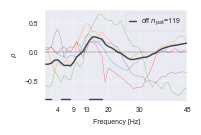

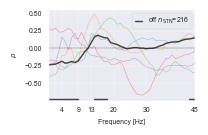

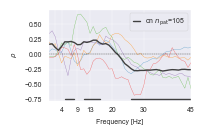

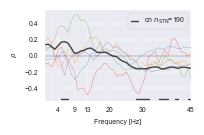

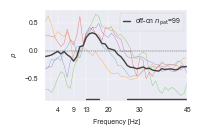

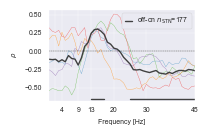

In [6]:
# y = "UPDRS_bradyrigid_contra"
# cond = 'offon_abs'
# for kind in ['normalized', 'absolute', 'periodic', 'periodicAP', 'periodicFULL', 'normalizedInce', 'lorentzian', 'lorentzianAP', 'lorentzianFULL']:
for kind in ['normalized']:
    if kind == 'normalized':
        df_plot = dataframes['df_norm']
        x = 'psd'
        xmax = 45
    elif kind  == 'absolute':
        df_plot = dataframes['df_abs']
        x = 'psd'
        xmax = 45
    elif kind == 'normalizedInce':
        df_plot = dataframes['df_normInce']
        x = 'psd'
        xmax = 45
    elif kind == 'lorentzian':
        df_plot = dataframes['df_lor100']
        x = 'fm_psd_peak_fit'
        xmax = 100
    elif kind == 'lorentzianAP':
        df_plot = dataframes['df_lor100']
        x = 'fm_psd_ap_fit'
        xmax = 100
    elif kind == 'lorentzianFULL':
        df_plot = dataframes['df_lor100']
        x = 'fm_fooofed_spectrum'
        xmax = 100
    elif kind  == 'periodic':
        df_plot = dataframes['df_abs']
        x = 'fm_psd_peak_fit'
        xmax = 40  # max for fm Litvak
    elif kind  == 'periodicAP':
        df_plot = dataframes['df_abs']
        x = 'fm_psd_ap_fit'
        xmax = 40  # max for fm Litvak
    elif kind  == 'periodicFULL':
        df_plot = dataframes['df_abs']
        x = 'fm_fooofed_spectrum'
        xmax = 40  # max for fm Litvak
    else:
        raise ValueError(f'Unknown kind {kind}')
    x += '_log'

    for cond in ['off', 'on', 'offon_abs']:
    # for cond in ['off']:
        # for corr_method in ['spearman', 'within', 'withinRank']:
        for corr_method in ['spearman']:
            for y in ['UPDRS_III', 'UPDRS_bradyrigid_contra']:
            # for y in ['UPDRS_III']:
                folder = 'Figure5' if corr_method.startswith('within') else KIND_DIR[kind]
                save_dir = f'{folder}/{ch_choice}/'
                data = df_plot[(df_plot.cond == cond)]

                # only plot all subjects pooled
                # data = data[data.project == 'all']

                df = df_corr_freq(data, x, y,
                                  n_perm=n_perm,
                                  corr_method=corr_method)
                # 1/0
                plot_psd_updrs_correlation(df, x, y, kind, save_dir=save_dir)

# Figure 2

all $\theta$ mean: rho=-0.26, p=0.00


all L$\beta$ mean: rho=-0.03, p=0.71


all L$\gamma$ mean: rho=-0.17, p=0.07


absolute off $n_{sub}=119$


Significant clusters: 0-11 Hz, 26-35 Hz


$\theta$ mean: rho=-0.26, pval=0.00
L$\beta$ mean: rho=-0.03, pval=0.71
L$\gamma$ mean: rho=-0.17, pval=0.07
all Offset: rho=-0.24, p=0.01


all L$\beta$ mean: rho=0.25, p=0.01


all L$\gamma$ mean: rho=-0.30, p=0.00


periodic off $n_{sub}=115$


Significant clusters: 4-7 Hz, 13-18 Hz, 29-45 Hz


Offset: rho=-0.24, pval=0.01
L$\beta$ mean: rho=0.25, pval=0.01
L$\gamma$ mean: rho=-0.30, pval=0.00


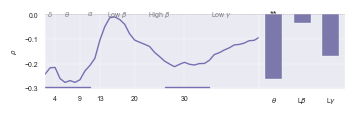

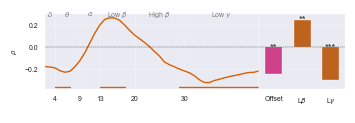

In [7]:
kinds_list = [
    ['absolute'],
    ['periodic'],


    # ['normalized', 'absolute'],
    # ['absolute', 'lorentzian', 'lorentzianAP'],
    # ['absolute', 'lorentzianFULL'],
    # ['absolute', 'lorentzian'],
    # ['lorentzianAP'],
    # ['lorentzian', 'lorentzianAP'],
    # ['lorentzian',
    #  'lorentzianAP',
    #  'lorentzianFULL'],
    # ['normalized', 'absolute', 'periodic', , 'periodicAP'],  # Figure 4
    # ['normalized', 'absolute', 'lorentzian', , 'lorentzianAP'],  # Figure 4
    # ['normalizedInce', 'lorentzian']  # Fig. Supp4
              ]

for kinds in kinds_list:
    figure2(kinds,
            corr_method='spearman',
            n_perm=n_perm,
            y='UPDRS_III',
            conds=['off'],
            xmax=45,
            )
    # break
#     figure2(kinds,
#             corr_method='spearman',
#             n_perm=None,
#             y='UPDRS_III',
#             conds=['off'],
#             xmax=60,
#             )

# Figure 5

In [8]:
dataframes = get_dfs(ch_choice, equalize_subjects_norm_abs=True)

/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/STN_broadband_power/notebooks/analysis_settings.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['sub_hemi_cond'] = df.sub_hemi + '_' + df.cond
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/STN_broadband_power/notebooks/analysis_settings.py:81: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pivot['UPDRS_exists'] = pivot.UPDRS_bradyrigid_contra.notna()
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/STN_broadband_power/notebooks/analysis_settings.py:82: 

In [9]:
kinds = ['absolute', 'periodic', 'periodicAP']
conds = ['off', 'on']
df_corrs = get_corrs_kinds(kinds, conds, n_perm, remove_ties=True)

100%|██████████| 10000/10000 [00:11<00:00, 903.71it/s]


/Users/moritzgerster/anaconda3/envs/aperiodic/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/Users/moritzgerster/anaconda3/envs/aperiodic/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/Users/moritzgerster/anaconda3/envs/aperiodic/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/Users/moritzgerster/anaconda3/envs/aperiodic/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Serie

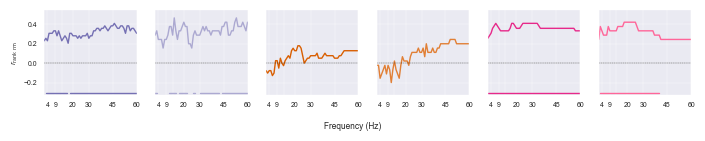

In [10]:
# no ties
plot_psd_updrs_correlation_multi(df_corrs, save_dir=f'Figure5/{ch_choice}/',
                                 legend=False, xmin=2, info_title=False,
                                 xlabel='Frequency (Hz)',
                                #  band_annos={'absolute': ['gamma_mid'],
                                #              'periodic': ['gamma'],
                                #              'periodicAP': ['gamma']},
                                 ylim=(-0.3, 0.55))

In [11]:
kinds = ['normalized']
conds = ['off', 'on']
df_corrs_norm = get_corrs_kinds(kinds, conds, n_perm, remove_ties=True)

100%|██████████| 10000/10000 [00:09<00:00, 1046.89it/s]


/Users/moritzgerster/anaconda3/envs/aperiodic/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/Users/moritzgerster/anaconda3/envs/aperiodic/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


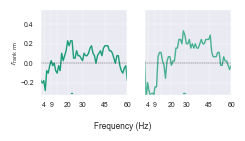

In [12]:
plot_psd_updrs_correlation_multi(df_corrs_norm, save_dir=f'Figure5/{ch_choice}/',
                                 legend=False, xmin=2, info_title=False,
                                 xlabel='Frequency (Hz)',
                                 figsize=(2.4, 1.3),
                                 ylim=(-0.3, 0.55))

# Supplementary Figure Adjacent Channels

In [13]:
ch_choice = 'ch_adj_beta_high_max_off'
dataframes = get_dfs(ch_choice, equalize_subjects_norm_abs=True)

/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/STN_broadband_power/notebooks/analysis_settings.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['sub_hemi_cond'] = df.sub_hemi + '_' + df.cond
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/STN_broadband_power/notebooks/analysis_settings.py:81: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pivot['UPDRS_exists'] = pivot.UPDRS_bradyrigid_contra.notna()
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/STN_broadband_power/notebooks/analysis_settings.py:82: 

In [14]:
kinds = ['absolute', 'periodic', 'periodicAP']
conds = ['off', 'on']
df_corrs = get_corrs_kinds(kinds, conds, n_perm, remove_ties=True)

100%|██████████| 10000/10000 [00:07<00:00, 1275.29it/s]


/Users/moritzgerster/anaconda3/envs/aperiodic/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/Users/moritzgerster/anaconda3/envs/aperiodic/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/Users/moritzgerster/anaconda3/envs/aperiodic/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/Users/moritzgerster/anaconda3/envs/aperiodic/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Serie

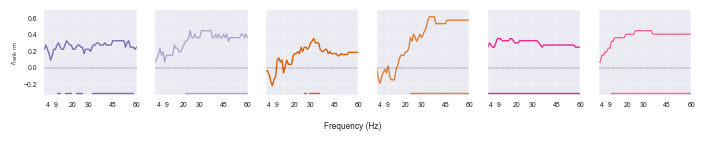

In [15]:
# no ties
plot_psd_updrs_correlation_multi(df_corrs, save_dir=f'Figure5/{ch_choice}/',
                                 legend=False, xmin=2, info_title=False,
                                 xlabel='Frequency (Hz)',
                                #  band_annos={'absolute': ['gamma_mid'],
                                #              'periodic': ['gamma'],
                                #              'periodicAP': ['gamma']},
                                 ylim=(-0.3, 0.7))

In [16]:
1/0

ZeroDivisionError: division by zero

In [ ]:
# kinds_list = [
#     ['normalized'],
#     ['absolute'],
#     ['periodic'],
#      ]

# for kinds in kinds_list:
#         figure5(kinds, conds=['off', 'on'],
#                 asymmetric_subjects=True,
#                 corr_method='withinRank',
#                 scale='log', rolling_mean=1,
#                 figsize=(2.5, 1.5),
#                 n_perm=n_perm, xmin=2, xmax=60, legend=True,
#                 )
#         # figure5(['normalized'], conds=['on'],
#         #         dominant_side_consistent=True,
#         #         corr_method='withinRank',
#         #         scale='log', rolling_mean=5,
#         #         n_perm=n_perm, xmin=2, xmax=60, legend=False,
#         #         )

NameError: name 'figure5' is not defined

## Figure 5 Supplementary

/Users/moritzgerster/anaconda3/envs/local_sns013/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/BIDS_STN_LFP/scripts/corr_stats.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged[x] = group[x].transform("mean")
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/BIDS_STN_LFP/scripts/corr_stats.py:289: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

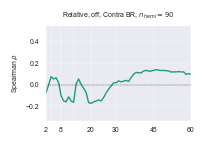

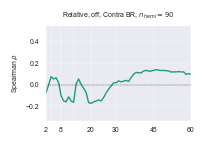

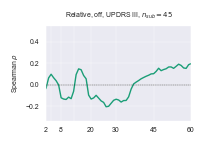

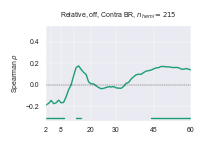

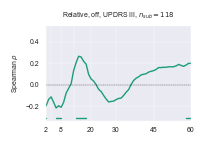

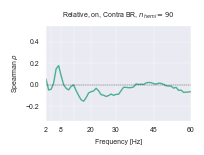

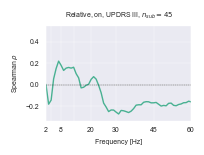

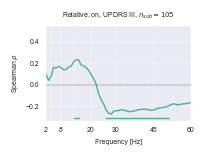

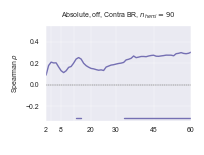

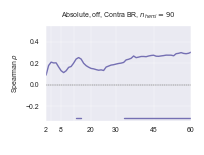

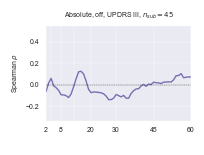

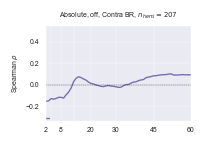

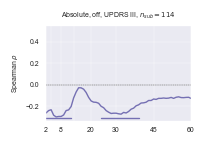

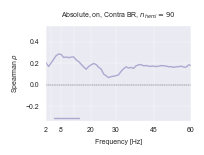

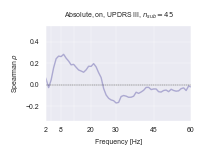

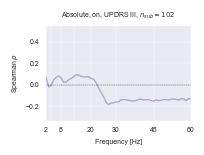

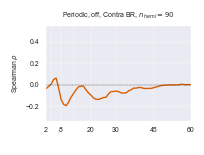

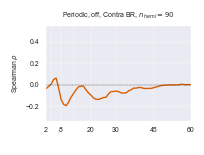

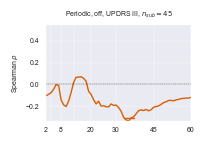

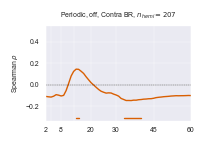

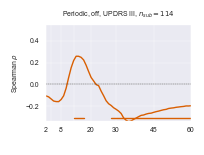

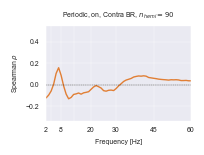

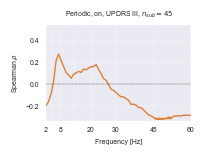

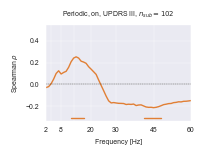

In [ ]:
n_perm = None
kinds_list = [
    ['normalized'],
    ['absolute'],
    ['periodic'],
     ]

for kinds in kinds_list:
    for cond in ['off', 'on']:
    # for cond in ['on']:
        for asymmetric_subjects in [True, None]:
        # for dominant_side_consistent in [True]:
            for y in ['UPDRS_bradyrigid_contra', 'UPDRS_III']:
            # for y in ['UPDRS_III']:
                for corr_method in ['spearman', 'withinRank']:
                    if (corr_method == 'spearman') and ((y == 'UPDRS_III') or (asymmetric_subjects is None)):
                        # withinRank not possible
                        continue
                    if (corr_method == 'withinRank') and (y == 'UPDRS_bradyrigid_contra') and (cond == 'on'):
                        # main figure, not supplementary
                        continue
                    figure5(kinds, conds=[cond],
                            asymmetric_subjects=asymmetric_subjects,
                            corr_method='spearman',
                            scale='log', rolling_mean=1, y=y,
                            n_perm=n_perm, xmin=2, xmax=60, legend=False,
                            annotate_bands=False, info_title=True,
                            )


In [ ]:
1/0

ZeroDivisionError: division by zero

/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/BIDS_STN_LFP/scripts/corr_stats.py:562: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_copy = df_copy.set_index(group)[hemi_both].reset_index()
100%|██████████| 10000/10000 [00:10<00:00, 924.97it/s]
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/BIDS_STN_LFP/scripts/corr_stats.py:562: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_copy = df_copy.set_index(group)[hemi_both].reset_index()
100%|██████████| 10000/10000 [00:09<00:00, 1091.66it/s]
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/BIDS_STN_LFP/scripts/corr_stats.py:562: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_copy = df_copy.set_index(group)[hemi_both].reset_index()
100%|██████████| 10000/10000 [00:08<00:00, 1129.22it/s]
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/BIDS_STN_LFP/scripts/corr_stats.py:562: UserWarning: Boolean Series key will be

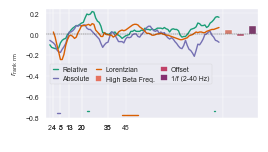

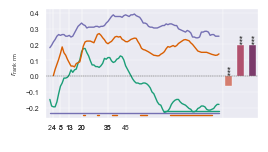

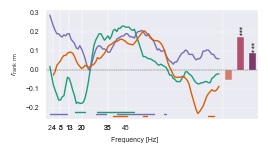

In [ ]:
kinds_list = [
    # ['normalized', 'absolute', 'periodic'],  # Figure 5
    ['normalized', 'absolute', 'lorentzian'],  # Figure 5
    # ['normalizedInce', 'lorentzian']  # Fig. Supp5
              ]

for kinds in kinds_list:
    figure5(kinds,
            corr_method='withinRank',
            # corr_method='within'
            n_perm=10000, rolling_mean=5,
            )

/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/BIDS_STN_LFP/scripts/corr_stats.py:562: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_copy = df_copy.set_index(group)[hemi_both].reset_index()
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/BIDS_STN_LFP/scripts/corr_stats.py:562: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_copy = df_copy.set_index(group)[hemi_both].reset_index()
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/BIDS_STN_LFP/scripts/corr_stats.py:562: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_copy = df_copy.set_index(group)[hemi_both].reset_index()
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/BIDS_STN_LFP/scripts/corr_stats.py:562: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_copy = df_copy.set_index(group)[hemi_both].reset_index()
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/BIDS_STN_LFP/

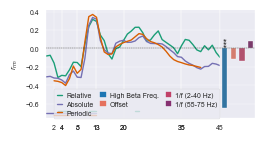

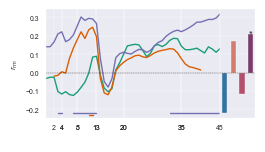

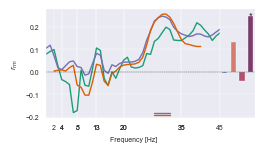

In [ ]:
kinds_list = [
    ['normalized', 'absolute', 'periodic'],  # Figure 5
    # ['normalizedInce', 'lorentzian']  # Fig. Supp5
              ]

for kinds in kinds_list:
    figure5(kinds,
            n_perm=10000
            )

# Correlate age with PSD as Martin 2018

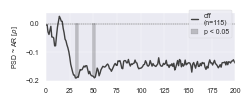

In [ ]:
y = "patient_age"
cond = 'off'
df_plot = dataframes['df_abs']
kind = 'absolute'
x = 'psd'
xmax = 200
x += '_log'
# for corr_method in ['spearman', 'within', 'withinRank']:
corr_method = 'spearman'
save_dir = 'Figure1/age/'
data = df_plot[(df_plot.cond == cond)]

        # only plot all subjects pooled!
data = data[data.project == 'all']
data = data.drop_duplicates(subset=['subject', 'cond'])

df = df_corr_freq(data, x, y, xmax=xmax,
                                n_perm=None,
                                corr_method=corr_method)
plot_psd_updrs_correlation(df, x, y, kind,
                                    save_dir=save_dir)